In [36]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
import sys

from itertools import combinations
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats, interp

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [70]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,AUC = True,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
        
        
        #Round predicted values for Regression model
#         if model_name == 'Random Forest Regressor':
#             for ypr in ypred:
#                 if ypr < 0:
#                     ypr = 0
#                 elif ypr > 4:
#                     ypr = 4
#                 else:
#                     ypr = round(ypr)
        
        if AUC:
            yscore = clf.predict_proba(Xte)
            if len(np.unique(yte))>1:
                yte_bin = label_binarize(yte, clf.classes_)
                for c in list(range(yte_bin.shape[1]))[::-1]:
                    if not any(yte_bin[:,c]):
                        yte_bin = np.delete(yte_bin,[c],axis=1)
                        yscore = np.delete(yscore,[c],axis=1)
                
                auroc = roc_auc_score(yte_bin,yscore,average='weighted')
                fpr_mean = np.array(range(0,101))/100
                tprs = []
                for i in range(yte_bin.shape[1]):
                    yt = yte_bin[:,i]
                    ys = yscore[:,i]
                    fpr, tpr, thresh = roc_curve(yt,ys)
                    tpr = interp(fpr_mean,fpr,tpr)*np.mean(yt)
                    tprs.append(tpr)

                tpr = sum(tprs)
                fpr = fpr_mean
                
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
                fpr = np.array([])
                tpr = np.array([])

            tpr_all.append(tpr)
            fpr_all.append(fpr)
            auroc_all.append(auroc)
                
            RMS_all.append(auroc)
            
        else:

            RMS=0
            for yp,yt in zip(ypred,y):
                RMS += ((yp - yt)**2)
            RMS = RMS / len(y)
            RMS = math.sqrt(RMS)

            RMS_all.append(RMS)

        groupres[model_name] = {'RMS':RMS_all, 'tpr': tpr_all, 'fpr':fpr_all}

        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [3]:
info = ['Subject','Visit','Task','Bradykinesia','Tremor']

featdict = {'freq':['Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew','PSD_kur'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ','skewX','skewY','skewZ','kurtX','kurtY','kurtZ','Sen_X','Sen_Y','Sen_Z'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_mean','jerk_std','jerk_skew','jerk_kur'],
            'mag' :['RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag','Sen_mag']}


#Accel+Gyro file has features labeled with 'acc' and 'gyr' 
def fix_feature_names(features):
    feats = features.copy()
    if feats[0][-3:] != 'acc':
        featlen = len(feats)
        for f in range(featlen):
            feats.append(feats[f] + ' gyr')
        for f in range(featlen):
            feats[f] = feats[f] + ' acc'
    return feats

featdictsensors = {}

for featgroup in featdict.keys():
    feats = fix_feature_names(featdict[featgroup])
    featdictsensors[featgroup] = feats

In [6]:
lst = featdict.keys()
combs = []
for i in range(len(lst)):
    els = [list(x) for x in combinations(lst, i+1)]
    combs.extend(els)

combs

[['freq'],
 ['time'],
 ['corr'],
 ['jerk'],
 ['mag'],
 ['freq', 'time'],
 ['freq', 'corr'],
 ['freq', 'jerk'],
 ['freq', 'mag'],
 ['time', 'corr'],
 ['time', 'jerk'],
 ['time', 'mag'],
 ['corr', 'jerk'],
 ['corr', 'mag'],
 ['jerk', 'mag'],
 ['freq', 'time', 'corr'],
 ['freq', 'time', 'jerk'],
 ['freq', 'time', 'mag'],
 ['freq', 'corr', 'jerk'],
 ['freq', 'corr', 'mag'],
 ['freq', 'jerk', 'mag'],
 ['time', 'corr', 'jerk'],
 ['time', 'corr', 'mag'],
 ['time', 'jerk', 'mag'],
 ['corr', 'jerk', 'mag'],
 ['freq', 'time', 'corr', 'jerk'],
 ['freq', 'time', 'corr', 'mag'],
 ['freq', 'time', 'jerk', 'mag'],
 ['freq', 'corr', 'jerk', 'mag'],
 ['time', 'corr', 'jerk', 'mag'],
 ['freq', 'time', 'corr', 'jerk', 'mag']]

In [7]:
datadict = {'watch':{},'sensor':{}}
datadict['watch']['Tremor'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
datadict['watch']['Bradykinesia'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
datadict['sensor']['Tremor'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel Data 62.5Hz.csv',index_col=0)
datadict['sensor']['Bradykinesia'] = pd.read_csv('//FS2.smpp.local\\RTO\\CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv',index_col=0)

In [41]:
model_name

['Random Forest']

In [ ]:
#skip this cell and open pkl file

t1 = time.time()
results = {}

for mode in ['watch','sensor']:
    
    results[mode] = {}
    
    for symptom in ['Tremor','Bradykinesia']:
        
        count = 0
        print(mode + ', ' + symptom)

        results[mode][symptom] = {}

        data = datadict[mode][symptom]

        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = {}

        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = {}

        for comb in combs:

            count += 1
            print('Combination %d of %d'%(count,len(combs)))
            
            feat_cols = []
            comb_group = ''

            for features_set in comb:

                comb_group += features_set[0]
                if mode == 'sensor' and symptom == 'Bradykinesia':
                    feat_cols = feat_cols + featdictsensors[features_set]
                else:
                    feat_cols = feat_cols + featdict[features_set]

            data_comb = data[info + feat_cols]

            Data = data_comb.copy() #original unmodified dataframe
            Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
            Data=Data.reset_index(drop=True) #reset index

            X = Data.iloc[:,5:].values
            groups = Data.Subject.values
            fnames = Data.iloc[:,5:].columns.values

            #Binary

            y = ((Data[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(Data,X,y,groups,model)
            res['Combination'] = comb_group
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups[comb_group] = res_group

            #Multiple Classes

            y = Data[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model,True)
            res['Combination'] = comb_group
            multi_res_groups[comb_group] = res_group
            R = pd.DataFrame()
            R['RMS'] = [np.nanmean(multi_res_groups[comb_group][model_name[0]]['RMS'])]
            R['Model'] = ['Random Forest']
            R['Combination'] = [comb_group]
            multi_res_all = pd.concat([multi_res_all,R])

#             #Regressor

#             y = Data[symptom].values.astype(int) #target 

#             model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
#             model_name = ['Random Forest Regressor']
#             model = list(zip(model,model_name))

#             res,res_group = LOSOMultiClass(Data,X,y,groups,model,False)
#             res['Combination'] = comb_group
#             regress_res_groups = pd.concat((regress_res_groups,res))
#             R = pd.DataFrame()
#             R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups.Combination==comb_group]['RMS'])]
#             R['Model'] = ['Random Forest'] 
#             R['Combination'] = [comb_group]
#             regress_res_all = pd.concat([regress_res_all,R])

        results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
        results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

        results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
        results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

#         results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
#         results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups

f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\FeaturesAnalysisResults','wb')
pickle.dump(results,f)
f.close()

print('Elapsed time = %.3f min'%((time.time()-t1)/60))

watch, Tremor
Combination 1 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 2 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 3 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 4 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 5 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 6 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 7 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 8 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 9 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 10 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 11 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 12 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 13 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 14 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 15 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 16 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 17 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 18 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 19 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 20 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 21 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 22 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 23 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 24 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 25 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 26 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 27 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 28 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 29 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest
Combination 30 of 31
Training Random Forest


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Training Random Forest


In [47]:
results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
results[mode][symptom]['Binary']['res_groups'] = binary_res_groups

results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups

In [61]:
results['watch']['Tremor']['Multiclass']['res_groups']

{'c': {'Random Forest': {'RMS': [0.9243856332703214,
    0.7739485981308412,
    0.9003872633390706,
    0.9375,
    0.5418994413407822,
    0.7524131274131274,
    0.645597561228956,
    0.9226190476190477,
    0.9585040983606558,
    0.6540978440012671,
    nan,
    0.6369606003752345,
    0.5912192238556254,
    0.9460648148148149],
   'fpr': [array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
           0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
           0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
           0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
           0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
           0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
           0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
           0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
           0.88, 0.89, 0.9 , 0.91, 0.92

In [7]:
#Open results as pickle file

f = open('//FS2.smpp.local\\RTO\\CIS-PD Study\\FeaturesAnalysisResults','rb')
results = pickle.load(f)
f.close()

In [43]:
def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [57]:
def ForwardSelection(mode,symptom,classifier,CIBound=False,CIZ=1.98,tol=.05):
    
    # Set plot parameters
    plotStyles = ['-', '--', '-.', ':', (0, (1, 10))]
    lw=5
    
    groups = results[mode][symptom][classifier]['res_all']['Combination'].values
    data = results[mode][symptom][classifier]['res_groups']
    
    done = False
    opt_feat = ''
    if classifier == 'Regressor':
        current_auc = sys.maxsize
    else:
        current_auc = 0
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['RMS']

    while not done:
        n = len(opt_feat)+1
        n_groups = [g for g in groups if (len(g)==n) & all([(o in g) for o in opt_feat])]
        if len(n_groups)<1:
            break
        auc_groups = np.array([AUC[g].mean()-np.nanmean(current_auc) for g in n_groups])
        auc_sem = np.array([stats.sem(AUC[g].values-current_auc, nan_policy='omit') for g in n_groups])
        
        if classifier == 'Regressor':
            auc_groups = auc_groups*-1

        if CIBound:
            opt_ind = np.argmax([auc_groups[i]-(CIZ*auc_sem[i]) for i in range(len(auc_groups))])
            gate = (auc_groups[opt_ind]-(CIZ*auc_sem[opt_ind]))>0
            print(auc_groups,auc_groups-CIZ*auc_sem)
        else:
            opt_ind = np.argmax(auc_groups)
            gate = auc_groups[opt_ind]>0
            print(auc_groups)

        if gate:
            opt_feat = n_groups[opt_ind]
            current_auc = AUC[opt_feat].values
            print(opt_feat,np.nanmean(current_auc))
        else:
            done = True

In [50]:
def BackwardSelection(mode,symptom,classifier,CIBound=False,CIZ=1.98,tol=.05):
    
    groups = results[mode][symptom][classifier]['res_all']['Combination'].values
    data = results[mode][symptom][classifier]['res_groups']
    
    done = False
    opt_feat = 'ftcjm'
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for i in range(len(data)):
            AUC[groups[i]] = data['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data['RMS'][data['Combination']==g].values

    current_auc = AUC[opt_feat]
            
    while not done:
        n = len(opt_feat)-1
        n_groups = [g for g in groups if (len(g)==n) & (g in opt_feat)]
        if len(n_groups)<1:
            break
        auc_groups = np.array([AUC[g].mean()-np.nanmean(current_auc) for g in n_groups])
        auc_sem = np.array([stats.sem(AUC[g].values-current_auc, nan_policy='omit') for g in n_groups])
        
        if classifier == 'Regressor':
            auc_groups = auc_groups*-1
        

        if CIBound:
            opt_ind = np.argmax([auc_groups[i]+(CIZ*auc_sem[i]) for i in range(len(auc_groups))])
            gate = (auc_groups[opt_ind]+(CIZ*auc_sem[opt_ind]))>0
            print(auc_groups,auc_groups+CIZ*auc_sem)
        else:
            opt_ind = np.argmax(auc_groups)
            gate = auc_groups[opt_ind]>0
            print(auc_groups)

        if gate:
            opt_feat = n_groups[opt_ind]
            current_auc = AUC[opt_feat].values
            print(opt_feat,np.nanmean(current_auc))
        else:
            done = True

In [52]:
'fj' in 'fjc'

True

In [28]:
mode = 'watch'; symptom = 'Tremor'; classifier = 'Binary'

In [30]:
results[mode][symptom][classifier]['res_all'].auroc.max()

0.772120818561465

In [25]:
data['Random Forest']

TypeError: list indices must be integers or slices, not str

In [58]:
ForwardSelection('watch','Tremor','Binary')

[0.63413155 0.74052714 0.70293304 0.64889291 0.72431716]
t 0.7405271366119716
[0.00062814]
ft 0.741155275140134


In [59]:
ForwardSelection('watch','Tremor','Multiclass')

[0.76929339 0.80725873 0.78350748 0.77464523 0.78991658]
t 0.8072587317299427
[0.00250512]
ft 0.8097638472249038


In [14]:
ForwardSelection('watch','Tremor','Binary',True,1.98)

[0.63413155 0.74052714 0.70293304 0.64889291 0.72431716] [0.5561089  0.62299899 0.61145263 0.5882491  0.6317809 ]
m 0.7243171609231217
[0.00568551 0.0166413  0.01482092 0.01067595] [-0.00728845 -0.02597617 -0.01494045 -0.00278013]


In [15]:
ForwardSelection('watch','Tremor','Multiclass',True,1.98)

[0.84974199 0.87744204 0.86787535 0.84151361 0.86516152] [0.82746547 0.85758264 0.84515859 0.82886906 0.84497939]
t 0.8774420376809227
[ 0.00223995 -0.00028647 -0.00019341  0.00155434] [ 0.00151393 -0.00111124 -0.00297754  0.00096791]
ft 0.8796819873538928
[ 0.0001442  -0.00053092 -0.00089848] [-0.00091946 -0.00125243 -0.00203974]


In [16]:
BackwardSelection('watch','Tremor','Binary')

[0.00352968 0.00171464]
ftcj 0.7544226582192712
[-0.0080438   0.00040092]
tcj 0.7548235737918247
[-0.00802939 -0.01859707]


In [17]:
BackwardSelection('watch','Tremor','Multiclass')

[-0.00084088 -0.0008137 ]


In [18]:
BackwardSelection('watch','Tremor','Binary',True,1.98)

[0.00352968 0.00171464] [0.01502936 0.01375465]
ftcj 0.7544226582192712
[-0.0080438   0.00040092] [-0.00028039  0.00883575]
tcj 0.7548235737918247
[-0.00802939 -0.01859707] [-0.00081505  0.00944363]
cj 0.7362265035291384
[-0.03329347 -0.08733359] [-0.00484324 -0.0366282 ]


In [19]:
BackwardSelection('watch','Tremor','Multiclass',True,1.98)

[-0.00084088 -0.0008137 ] [-0.0001447  -0.00016035]


In [20]:
ForwardSelection('watch','Bradykinesia','Binary')

[0.59084047 0.60495845 0.61465267 0.57637163 0.59504909]
c 0.6146526709416694
[-0.00688353  0.00202408 -0.00488358 -0.00147213]
tc 0.6166767523606963
[-0.00924507 -0.00231573 -0.00332614]


In [21]:
ForwardSelection('watch','Bradykinesia','Multiclass')

[0.67986392 0.70386007 0.71512947 0.65523311 0.6669344 ]
c 0.7151294699959994
[ 0.00674911 -0.00554494 -0.01090295 -0.00600359]
fc 0.7218785785635434
[-0.01309375 -0.00758576 -0.01707777]


In [22]:
ForwardSelection('watch','Bradykinesia','Binary',True,1.98)

[0.59084047 0.60495845 0.61465267 0.57637163 0.59504909] [0.53903998 0.54744566 0.5522752  0.51923741 0.53291753]
c 0.6146526709416694
[-0.00688353  0.00202408 -0.00488358 -0.00147213] [-0.02869863 -0.02855829 -0.02502203 -0.0239676 ]


In [23]:
ForwardSelection('watch','Bradykinesia','Multiclass',True,1.98)

[0.67986392 0.70386007 0.71512947 0.65523311 0.6669344 ] [0.67053206 0.68736714 0.69952728 0.64886901 0.65767321]
c 0.7151294699959994
[ 0.00674911 -0.00554494 -0.01090295 -0.00600359] [ 0.00295021 -0.01203247 -0.01268232 -0.00994019]
fc 0.7218785785635434
[-0.01309375 -0.00758576 -0.01707777] [-0.01806382 -0.00906044 -0.01912908]


In [24]:
BackwardSelection('watch','Bradykinesia','Binary')

[ 0.00427031 -0.00541588]
ftcj 0.6262974145112475
[-0.01886573 -0.01193639]


In [25]:
BackwardSelection('watch','Bradykinesia','Multiclass')

[-0.00177769 -0.00268218]


In [26]:
BackwardSelection('watch','Bradykinesia','Binary',True,1.98)

[ 0.00427031 -0.00541588] [0.01313263 0.00483634]
ftcj 0.6262974145112475
[-0.01886573 -0.01193639] [-0.0070124  -0.00332865]


In [27]:
BackwardSelection('watch','Bradykinesia','Multiclass',True,1.98)

[-0.00177769 -0.00268218] [ 0.00069217 -0.00070145]
ftcj 0.7155358747327298
[-0.00675105 -0.00059349] [-0.00544966  0.00179633]
tcj 0.7149423829992355
[-0.00535785 -0.01071587] [-0.00373034 -0.00537519]


In [53]:
from sklearn.feature_selection import RFE

In [ ]:
RFE

In [87]:
m = np.mean([0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051])
s = np.std([0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051])

In [142]:
[-9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18, -9.223372036854776e+18]*-1

[]

In [115]:
mode = 'watch'; symptom = 'Tremor'; classifier = 'Binary'; CIBound = True; CIZ = 1.98

groups = results[mode][symptom][classifier]['res_all']['Combination'].values
data = results[mode][symptom][classifier]['res_groups']

done = False
opt_feat = ''
current_auc = 0

if classifier == 'Binary':

    AUC = pd.DataFrame()
    for i in range(len(data)):
        AUC[groups[i]] = data[i]['Random Forest']['auroc']


    while not done:
        n = len(opt_feat)+1
        n_groups = [g for g in groups if (len(g)==n) & all([(o in g) for o in opt_feat])]
        if len(n_groups)<1:
            break
        auc_groups = [AUC[g].mean()-np.nanmean(current_auc) for g in n_groups]
        auc_sem = [stats.sem(aucdf[g].values-current_auc, nan_policy='omit') for g in n_groups]
        print(auc_groups,[g-CIZ*s for g,s in zip(auc_groups, auc_sem)])
        max_ind = np.argmax(auc_groups)
        if CIBound:
            if (auc_groups[max_ind]-(CIZ*auc_sem[max_ind]))>0:
                opt_feat = n_groups[max_ind]
                current_auc = aucdf[opt_feat].values
                print(opt_feat,current_auc)
            else:
                done = True
        else:
            if auc_groups[max_ind]>np.mean(current_auc):
                opt_feat = n_groups[max_ind]
                current_auc = AUC[opt_feat]
                print(opt_feat,current_auc)
            else:
                done = True

[0.6352951233281823, 0.7422959437907404, 0.6841052040488516, 0.6481000388384809, 0.7196329789918051] [0.5584174275461221, 0.6241088839085511, 0.601897422547087, 0.5863983287020665, 0.6271129660188752]
t [0.70561294 0.81037706 0.86186017 0.73196066 0.35612374 0.72138692
 0.7516752  0.99869281 0.94657467 0.82804711        nan 0.24381238
 0.86427346 0.82945014]
[0.00016780670521299168, 0.002212182690734754, 0.006437808633695585, -0.0009021098001887884] [-0.008308870837258852, -0.0026934758857538174, -0.0051464284074526825, -0.009070958307743392]


In [106]:
auc_sem

[nan, nan, nan, nan, nan]

In [10]:
def barplotFeatures(mode,symptom,classifier):
    if classifier == 'Binary':
        groups = results[mode][symptom][classifier]['res_all']['Combination'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
    else:
        groups = results[mode][symptom][classifier]['res_groups']['Combination']
        RMS = results[mode][symptom][classifier]['res_groups']['RMS']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('RMS')
        m = results[mode][symptom][classifier]['res_all']['RMS'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,m])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Feature Sets')
    plt.title('%s Model Performance v. %s Features: %s'%(classifier,mode,symptom))
    print('f: frequency')
    print('t: time')
    print('c: correlation')
    print('j: jerk')
    print('m: mag')
    
    plt.savefig('Results/Features_%s_%s_%s.png'%(mode,symptom,classifier),format='png',dpi=1000)

In [11]:
def stats_tests(mode,symptom,classifier):
    #dataframe for reorganizing data
    df = pd.DataFrame()
    comblist = list(results[mode][symptom][classifier]['res_all']['Combination'])
    if classifier == 'Binary':
        for i in range(len(comblist)):
            comb = comblist[i]
            df[comb] = pd.Series(results[mode][symptom][classifier]['res_groups'][i]['Random Forest']['auroc'])
        df = df[~df['f'].isnull()].reset_index(drop=True)
    else:
        for comb in comblist:
            df[comb] = results[mode][symptom][classifier]['res_groups'][results[mode][symptom][classifier]['res_groups']['Combination']==comb]['RMS']
        df = df.reset_index(drop=True)

    #rmANOVA
    print()
    print('Repeated Measures ANOVA')
    print('All feature subsets')
    print('pvalue: ' + str(rmANOVA(df,df.columns.values)))
    print('f,t,j,c,m,ftcjm')
    print('pvalue: ' + str(rmANOVA(df,['f','t','j','c','m','ftcjm'])))
    print()
    
    #t tests
    for comb in ['f','t','c','j','m']:
        p = stats.ttest_rel(df['ftcjm'],df[comb])
        print('ftcjm, %s'%comb)
        print(p)

In [12]:
def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return stats.f.sf(F,dfbw,dferror)

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.2407294855751674e-15
f,t,j,c,m,ftcjm
pvalue: 1.838185647828629e-05

ftcjm, f
Ttest_relResult(statistic=4.013325133360871, pvalue=0.0017199744127328195)
ftcjm, t
Ttest_relResult(statistic=1.145317907406181, pvalue=0.27440615312625705)
ftcjm, c
Ttest_relResult(statistic=2.676990119814746, pvalue=0.02014873731864096)
ftcjm, j
Ttest_relResult(statistic=2.8353209569720144, pvalue=0.015026630531448171)
ftcjm, m
Ttest_relResult(statistic=1.5633100588561193, pvalue=0.14395488627636344)


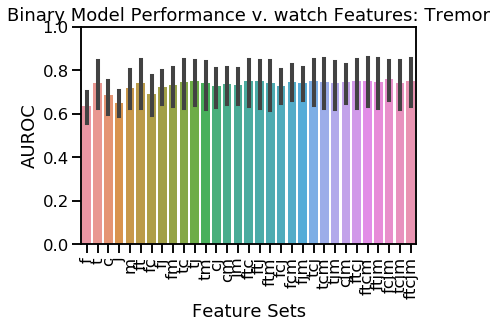

In [14]:
barplotFeatures('watch','Tremor','Binary')
stats_tests('watch','Tremor','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 8.80291136016951e-69
f,t,j,c,m,ftcjm
pvalue: 8.555604610338152e-11

ftcjm, f
Ttest_relResult(statistic=-6.497546731549849, pvalue=2.011257077481974e-05)
ftcjm, t
Ttest_relResult(statistic=-9.137665359108434, pvalue=5.069081163280519e-07)
ftcjm, c
Ttest_relResult(statistic=1.4452832072014001, pvalue=0.1720505627928243)
ftcjm, j
Ttest_relResult(statistic=-4.235692478549739, pvalue=0.000972729585186152)
ftcjm, m
Ttest_relResult(statistic=-11.322280814619132, pvalue=4.183404420131731e-08)


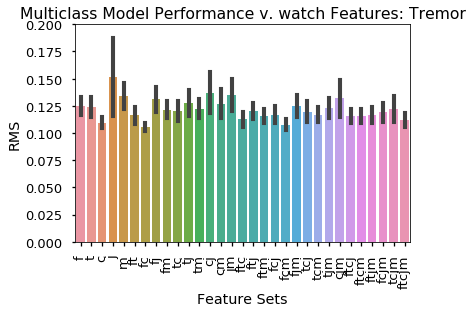

In [98]:
barplotFeatures('watch','Tremor','Multiclass')
stats_tests('watch','Tremor','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 3.2011690391667044e-37
f,t,j,c,m,ftcjm
pvalue: 2.956897821741187e-07

ftcjm, f
Ttest_relResult(statistic=-7.4468636820002505, pvalue=4.855684711357836e-06)
ftcjm, t
Ttest_relResult(statistic=-1.123970306635543, pvalue=0.28135253683103006)
ftcjm, c
Ttest_relResult(statistic=-7.155904374450818, pvalue=7.413102626725193e-06)
ftcjm, j
Ttest_relResult(statistic=-3.5763197236104003, pvalue=0.0033816465118064196)
ftcjm, m
Ttest_relResult(statistic=-8.411565292257393, pvalue=1.2857220922194676e-06)


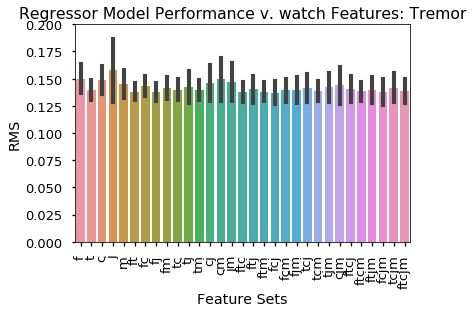

In [99]:
barplotFeatures('watch','Tremor','Regressor')
stats_tests('watch','Tremor','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 0.02236252961477201
f,t,j,c,m,ftcjm
pvalue: 0.014054486068820295

ftcjm, f
Ttest_relResult(statistic=2.071765291305611, pvalue=0.05874189913100713)
ftcjm, t
Ttest_relResult(statistic=0.7806440727035838, pvalue=0.4489938411327704)
ftcjm, c
Ttest_relResult(statistic=0.837624645353771, pvalue=0.4173755872893369)
ftcjm, j
Ttest_relResult(statistic=3.4065091692527414, pvalue=0.004683385101066986)
ftcjm, m
Ttest_relResult(statistic=1.9695213695148555, pvalue=0.07058120004170562)


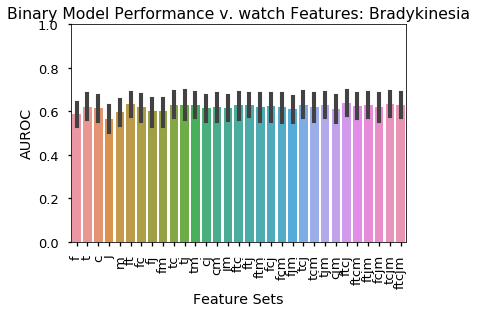

In [100]:
barplotFeatures('watch','Bradykinesia','Binary')
stats_tests('watch','Bradykinesia','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.169488526057966e-57
f,t,j,c,m,ftcjm
pvalue: 3.0065664718046995e-13

ftcjm, f
Ttest_relResult(statistic=-6.404954473630804, pvalue=2.3251877057090184e-05)
ftcjm, t
Ttest_relResult(statistic=-7.666402147095121, pvalue=3.5535325752105695e-06)
ftcjm, c
Ttest_relResult(statistic=-1.9177089935629226, pvalue=0.07738298318668856)
ftcjm, j
Ttest_relResult(statistic=-3.551367051969363, pvalue=0.0035471135837327927)
ftcjm, m
Ttest_relResult(statistic=-7.083949255728951, pvalue=8.244568064282004e-06)


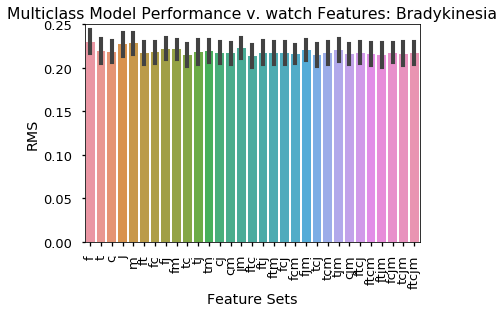

In [101]:
barplotFeatures('watch','Bradykinesia','Multiclass')
stats_tests('watch','Bradykinesia','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 2.8273466972509897e-40
f,t,j,c,m,ftcjm
pvalue: 0.0078120004404435665

ftcjm, f
Ttest_relResult(statistic=-0.8561662213664254, pvalue=0.4074105222362535)
ftcjm, t
Ttest_relResult(statistic=-3.8041630642022466, pvalue=0.0021899497866711)
ftcjm, c
Ttest_relResult(statistic=3.667981102590287, pvalue=0.0028382080301270008)
ftcjm, j
Ttest_relResult(statistic=0.5238851211355995, pvalue=0.6091744613152681)
ftcjm, m
Ttest_relResult(statistic=-3.3576957182615135, pvalue=0.00514402684981597)


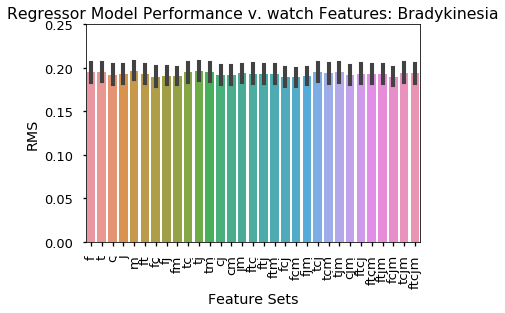

In [102]:
barplotFeatures('watch','Bradykinesia','Regressor')
stats_tests('watch','Bradykinesia','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 4.913549054689126e-29
f,t,j,c,m,ftcjm
pvalue: 4.2425835276363614e-09

ftcjm, f
Ttest_relResult(statistic=4.357283373280962, pvalue=0.00114144646344756)
ftcjm, t
Ttest_relResult(statistic=1.8050029230751985, pvalue=0.098489939742494)
ftcjm, c
Ttest_relResult(statistic=5.631242779591054, pvalue=0.0001530219102856899)
ftcjm, j
Ttest_relResult(statistic=3.6137452250176443, pvalue=0.0040707760701365085)
ftcjm, m
Ttest_relResult(statistic=0.8157908024144905, pvalue=0.4319303500086208)


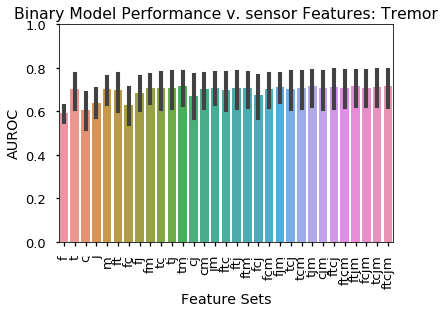

In [103]:
barplotFeatures('sensor','Tremor','Binary')
stats_tests('sensor','Tremor','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 8.906097194895458e-69
f,t,j,c,m,ftcjm
pvalue: 6.546562983963116e-14

ftcjm, f
Ttest_relResult(statistic=-3.570893216984144, pvalue=0.003846075232328544)
ftcjm, t
Ttest_relResult(statistic=-5.893765293080565, pvalue=7.323159141508633e-05)
ftcjm, c
Ttest_relResult(statistic=-2.4358245379721595, pvalue=0.03139655735073362)
ftcjm, j
Ttest_relResult(statistic=-5.043564930979698, pvalue=0.00028758868633502725)
ftcjm, m
Ttest_relResult(statistic=-9.809724200778808, pvalue=4.4057305548799193e-07)


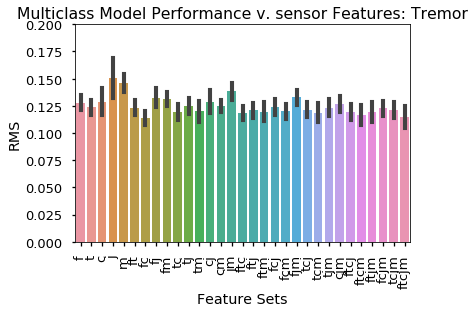

In [104]:
barplotFeatures('sensor','Tremor','Multiclass')
stats_tests('sensor','Tremor','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.218660030331608e-46
f,t,j,c,m,ftcjm
pvalue: 2.1175555596730666e-08

ftcjm, f
Ttest_relResult(statistic=-6.807450979507581, pvalue=1.8828065541660424e-05)
ftcjm, t
Ttest_relResult(statistic=-7.7068055584924355, pvalue=5.49885521147907e-06)
ftcjm, c
Ttest_relResult(statistic=-4.056460445584815, pvalue=0.0015917768386960213)
ftcjm, j
Ttest_relResult(statistic=-4.248108015498546, pvalue=0.001131090549937487)
ftcjm, m
Ttest_relResult(statistic=-15.076633720714018, pvalue=3.666374153420389e-09)


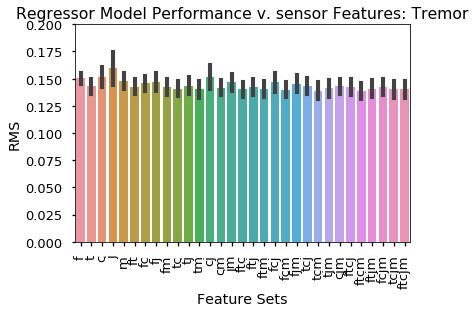

In [105]:
barplotFeatures('sensor','Tremor','Regressor')
stats_tests('sensor','Tremor','Regressor')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.0464594904077247e-23
f,t,j,c,m,ftcjm
pvalue: 7.1816811720361404e-06

ftcjm, f
Ttest_relResult(statistic=2.6019451072695254, pvalue=0.023142777884312345)
ftcjm, t
Ttest_relResult(statistic=-1.6025145159401066, pvalue=0.13502241540277649)
ftcjm, c
Ttest_relResult(statistic=5.153503037105223, pvalue=0.0002395936405312925)
ftcjm, j
Ttest_relResult(statistic=3.2989621823362896, pvalue=0.006352951981568172)
ftcjm, m
Ttest_relResult(statistic=2.180479433680845, pvalue=0.04985100470654528)


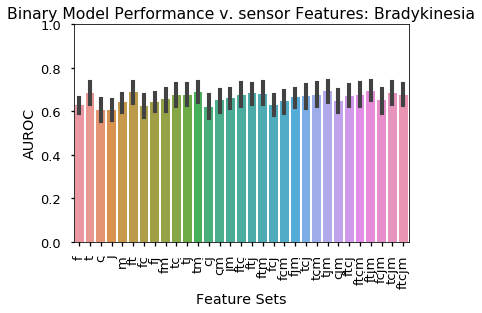

In [106]:
barplotFeatures('sensor','Bradykinesia','Binary')
stats_tests('sensor','Bradykinesia','Binary')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 5.480002033406227e-35
f,t,j,c,m,ftcjm
pvalue: 6.822754677101919e-10

ftcjm, f
Ttest_relResult(statistic=-1.7117383346874868, pvalue=0.11264326340178274)
ftcjm, t
Ttest_relResult(statistic=-2.408604035271517, pvalue=0.03299670572989949)
ftcjm, c
Ttest_relResult(statistic=-3.7259979431812074, pvalue=0.0028949952958685784)
ftcjm, j
Ttest_relResult(statistic=-1.5335150670261695, pvalue=0.15108117972836227)
ftcjm, m
Ttest_relResult(statistic=-11.49797843992827, pvalue=7.773795266251136e-08)


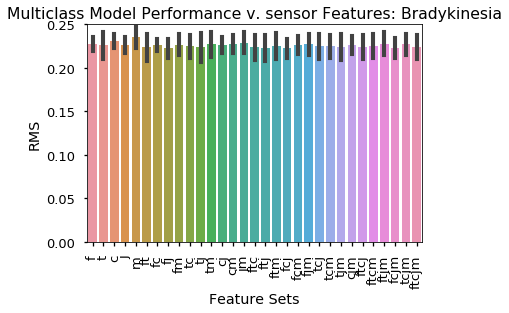

In [107]:
barplotFeatures('sensor','Bradykinesia','Multiclass')
stats_tests('sensor','Bradykinesia','Multiclass')

f: frequency
t: time
c: correlation
j: jerk
m: mag

Repeated Measures ANOVA
All feature subsets
pvalue: 1.4259586406033631e-21
f,t,j,c,m,ftcjm
pvalue: 2.8026025859182626e-05

ftcjm, f
Ttest_relResult(statistic=-1.4427561509533138, pvalue=0.17467984338227868)
ftcjm, t
Ttest_relResult(statistic=-8.155921998435492, pvalue=3.0839935042733542e-06)
ftcjm, c
Ttest_relResult(statistic=-6.247577439293316, pvalue=4.2699047868308586e-05)
ftcjm, j
Ttest_relResult(statistic=-0.204055681767295, pvalue=0.8417296959472884)
ftcjm, m
Ttest_relResult(statistic=-6.889190704028311, pvalue=1.676467917156864e-05)


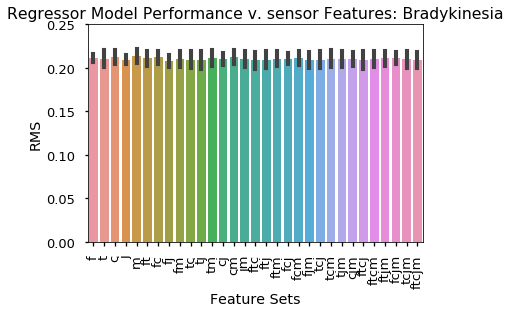

In [108]:
barplotFeatures('sensor','Bradykinesia','Regressor')
stats_tests('sensor','Bradykinesia','Regressor')